[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fast Segment Anything Model (FastSAM)

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/CASIA-IVA-Lab/FastSAM)
[![arXiv](https://img.shields.io/badge/arXiv-2306.12156-b31b1b.svg)](https://arxiv.org/pdf/2306.12156.pdf)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-fastsam)

The Fast Segment Anything Model (FastSAM) is a CNN Segment Anything Model trained by only 2% of the SA-1B dataset published by SAM authors.

![fast-segment-anything-model-figure-1](https://media.roboflow.com/notebooks/examples/fast-sam-figure-1.png)

The FastSAM authors claim it achieves comparable performance to the SAM method at 50 times the speed.

![fast-segment-anything-model-figure-2](https://media.roboflow.com/notebooks/examples/fast-sam-figure-2.png)

## Complementary Materials Covering SAM

---

[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/segment-anything)
[![arXiv](https://img.shields.io/badge/arXiv-2304.02643-b31b1b.svg)](https://arxiv.org/abs/2304.02643)
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-segment-anything-with-sam.ipynb)
[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/D-D6ZmadzPE)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/how-to-use-segment-anything-model-sam)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Install FastSAM, SAM, and other dependencies
- Download FastSAM and SAM weights
- Download example data
- Imports
- Load FastSAM
- FastSAM inference
- FastSAM box prompt inference
- FastSAM point prompt inference
- FastSAM text prompt inference
- SAM vs FastSAM
- Roboflow benchmark dataset

## 🔥 Let's begin!

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Thu Jul  6 09:24:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    31W /  70W |   2613MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [ ]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content/FastSAM


## Install FastSAM, SAM, and other dependencies

In [ ]:
%cd {HOME}

# install FastSAM
!git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
!pip -q install -r FastSAM/requirements.txt
# install CLIP
!pip -q install git+https://github.com/openai/CLIP.git
# install SAM
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
# install other dependencies
!pip -q install roboflow supervision jupyter_bbox_widget

/content/FastSAM
Cloning into 'FastSAM'...
remote: Enumerating objects: 589, done.
remote: Counting objects: 100% (96/96), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 589 (delta 56), reused 61 (delta 47), pack-reused 493
Receiving objects: 100% (589/589), 65.97 MiB | 9.65 MiB/s, done.
Resolving deltas: 100% (325/325), done.
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done


## Download FastSAM and SAM weights

In [ ]:
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://huggingface.co/spaces/An-619/FastSAM/resolve/main/weights/FastSAM.pt
!wget -P {HOME}/weights -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!ls -lh {HOME}/weights

total 2.6G
-rw-r--r-- 1 root root 139M Jun 20 07:01 FastSAM.pt
-rw-r--r-- 1 root root 2.4G Apr  4 06:56 sam_vit_h_4b8939.pth


In [ ]:
FAST_SAM_CHECKPOINT_PATH = f"{HOME}/weights/FastSAM.pt"
SAM_SAM_CHECKPOINT_PATH = f"{HOME}/weights/sam_vit_h_4b8939.pth"

## Download example data

**NONE:** Let's download few example images. Feel free to use your images or videos.

In [ ]:
!mkdir -p {HOME}/data
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -P {HOME}/data -q https://media.roboflow.com/notebooks/examples/robot.jpeg
!ls -lh {HOME}/data

total 532K
-rw-r--r-- 1 root root 104K Jun  2 16:01 dog.jpeg
-rw-r--r-- 1 root root 426K Jul  5 17:33 robot.jpeg


## Imports

**NOTE:** `FastSAM` code is not distributed via `pip` not it is packaged. Make sure to run code balow from `{HOME}/FastSAM` directory. ⚠️

In [ ]:
%cd {HOME}/FastSAM

import os
import cv2
import torch
import roboflow
import base64

import supervision as sv
import numpy as np

from roboflow import Roboflow
from fastsam import FastSAM, FastSAMPrompt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

/content/FastSAM/FastSAM


## Load FastSAM

In [ ]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

fast_sam = FastSAM(FAST_SAM_CHECKPOINT_PATH)

## FastSAM inference

* `retina_masks=True` determines whether the model uses retina masks for generating segmentation masks.
* `imgsz=1024` sets the input image size to 1024x1024 pixels for processing by the model.
* `conf=0.4` sets the minimum confidence threshold for object detection.
* `iou=0.9` sets the minimum intersection over union threshold for non-maximum suppression to filter out duplicate detections.

In [ ]:
IMAGE_PATH = f"{HOME}/data/dog.jpeg"

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.4,
    iou=0.9)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()
prompt_process.plot(annotations=masks, output=f"{HOME}/output")


image 1/1 /content/FastSAM/data/dog.jpeg: 1024x576 41 objects, 101.3ms
Speed: 5.6ms preprocess, 101.3ms inference, 7.7ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.everything_prompt` returns `torch.Tensor`

In [ ]:
def annotate_image(image_path: str, masks: np.ndarray) -> np.ndarray:
    image = cv2.imread(image_path)

    xyxy = sv.mask_to_xyxy(masks=masks)
    detections = sv.Detections(xyxy=xyxy, mask=masks)

    mask_annotator = sv.MaskAnnotator()
    return mask_annotator.annotate(scene=image.copy(), detections=detections)

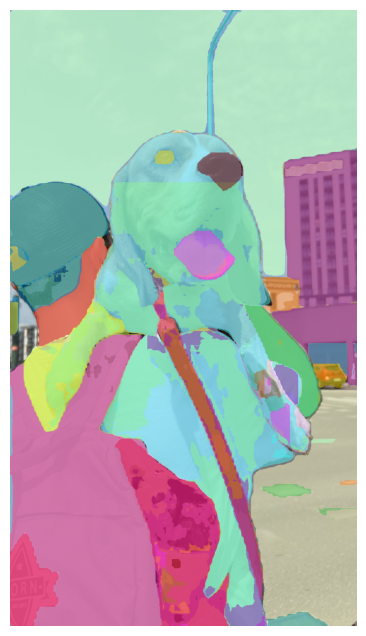

In [ ]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

**NOTE:** The quality of the generated masks is quite poor. Let's see if we can improve it by manipulating the parameters.

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()


image 1/1 /content/FastSAM/data/dog.jpeg: 1024x576 30 objects, 101.7ms
Speed: 5.6ms preprocess, 101.7ms inference, 6.9ms postprocess per image at shape (1, 3, 1024, 1024)


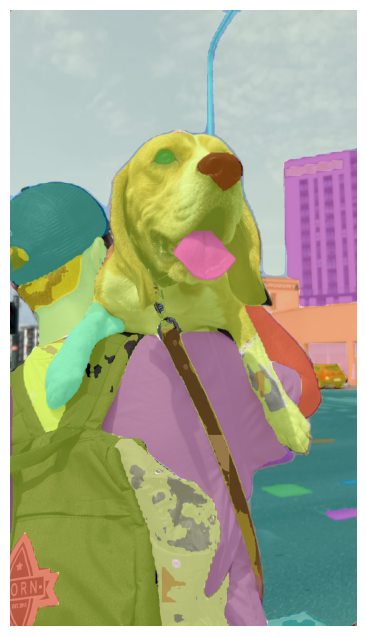

In [ ]:
masks = masks.cpu().numpy().astype(bool)
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM box prompt inference

### Draw Box

In [ ]:
# helper function that loads an image before adding it to the widget

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

**NOTE:** Execute cell below and use your mouse to draw bounding box on the image 👇

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image(IMAGE_PATH)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 335, 'y': 450, 'width': 140, 'height': 115, 'label': ''}]

### Generate mask with FastSAM

In [ ]:
# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 68, 'y': 247, 'width': 555, 'height': 678, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
box = [
    box['x'],
    box['y'],
    box['x'] + box['width'],
    box['y'] + box['height']
]

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.box_prompt(bbox=box)


image 1/1 /content/FastSAM/data/dog.jpeg: 1024x576 30 objects, 104.8ms
Speed: 3.6ms preprocess, 104.8ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.box_prompt` returns `numy.ndarray`

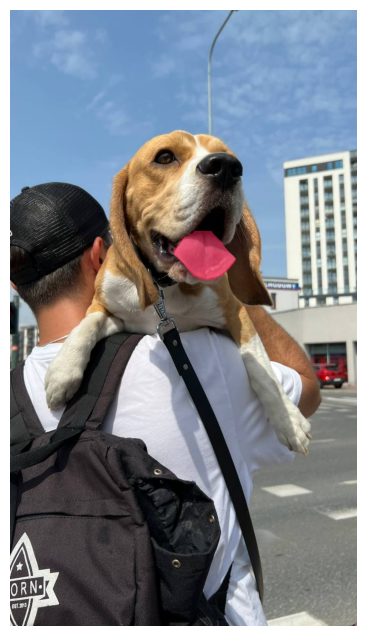

In [ ]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM point prompt inference

### Select point

In [ ]:
point = [405, 505]

### Generate mask with FastSAM

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.point_prompt(points=[point], pointlabel=[1])


image 1/1 /content/FastSAM/data/dog.jpeg: 1024x576 30 objects, 106.7ms
Speed: 5.3ms preprocess, 106.7ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)


**NOTE:** `prompt_process.point_prompt` returns `numy.ndarray`

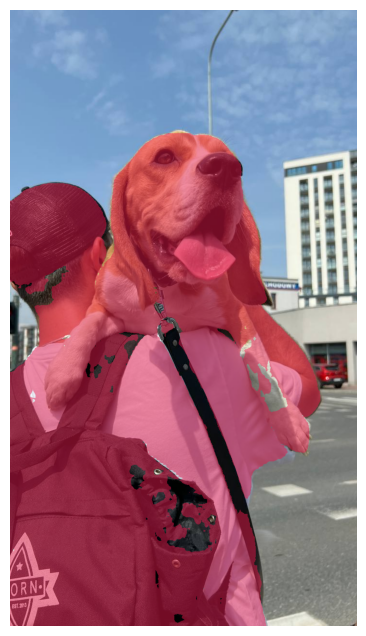

In [ ]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## FastSAM text prompt inference

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='cap')


image 1/1 /content/data/dog.jpeg: 1024x576 30 objects, 103.8ms
Speed: 3.4ms preprocess, 103.8ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)
100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 63.2MiB/s]


**NOTE:** `prompt_process.text_prompt` returns `numy.ndarray`

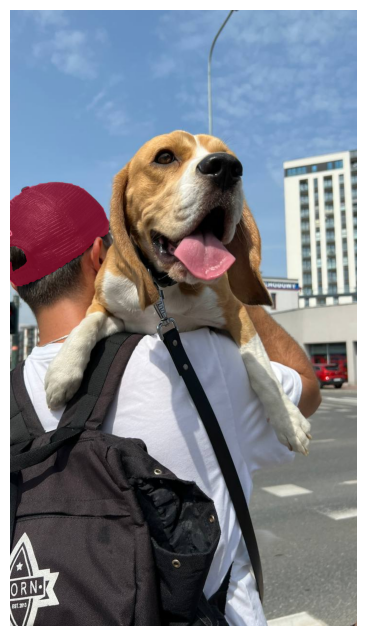

In [ ]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

##  SAM vs FastSAM

In [ ]:
IMAGE_PATH = f"{HOME}/data/robot.jpeg"

### Load SAM

In [ ]:
MODEL_TYPE = "vit_h"

sam = sam_model_registry[MODEL_TYPE](checkpoint=SAM_SAM_CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

### SAM inference

In [ ]:
image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

sam_result = mask_generator.generate(image_rgb)
sam_detections = sv.Detections.from_sam(sam_result=sam_result)

### FastSAM inference

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.everything_prompt()
masks = masks.cpu().numpy().astype(bool)
xyxy = sv.mask_to_xyxy(masks=masks)
fast_sam_detections = sv.Detections(xyxy=xyxy, mask=masks)


image 1/1 /content/data/robot.jpeg: 640x1024 68 objects, 231.0ms
Speed: 14.7ms preprocess, 231.0ms inference, 8.9ms postprocess per image at shape (1, 3, 1024, 1024)


### FastSAM vs. SAM

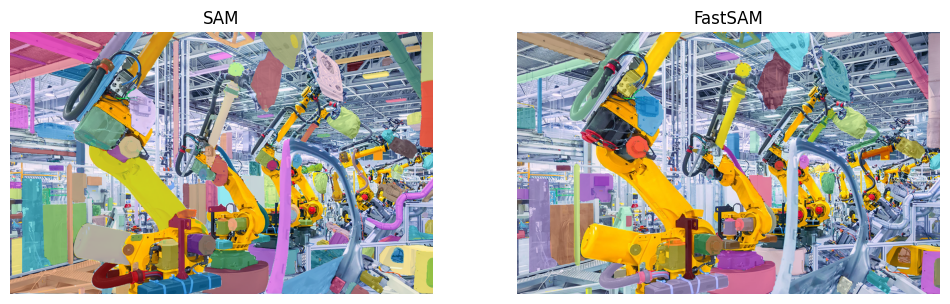

In [ ]:
mask_annotator = sv.MaskAnnotator()

sam_result = mask_annotator.annotate(scene=image_bgr.copy(), detections=sam_detections)
fast_sam_result = mask_annotator.annotate(scene=image_bgr.copy(), detections=fast_sam_detections)

sv.plot_images_grid(
    images=[sam_result, fast_sam_result],
    grid_size=(1, 2),
    titles=['SAM', 'FastSAM']
)

**NOTE:** There is a lot going on in our test image. Let's plot our masks against a blank background.

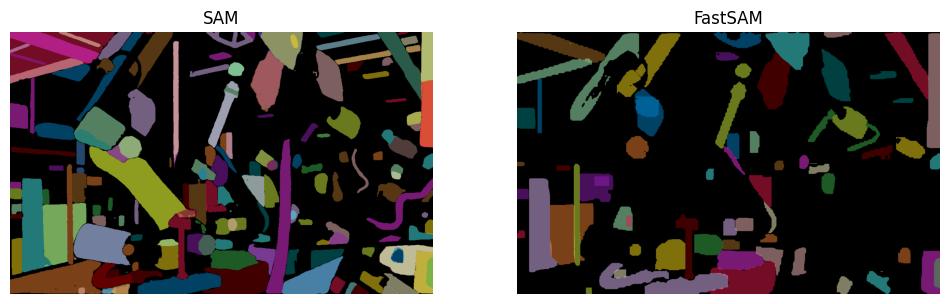

In [ ]:
mask_annotator = sv.MaskAnnotator()

sam_result = mask_annotator.annotate(scene=np.zeros_like(image_bgr), detections=sam_detections)
fast_sam_result = mask_annotator.annotate(scene=np.zeros_like(image_bgr), detections=fast_sam_detections)

sv.plot_images_grid(
    images=[sam_result, fast_sam_result],
    grid_size=(1, 2),
    titles=['SAM', 'FastSAM']
)

### Mask diff

**NOTE:** Let's try to understand which masks generated by SAM were not generated by FastSAM.

In [ ]:
def compute_iou(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return np.sum(intersection) / np.sum(union)

def filter_masks(mask_array1, mask_array2, threshold):
    return np.array([mask1 for mask1 in mask_array1 if max(compute_iou(mask1, mask2) for mask2 in mask_array2) < threshold])

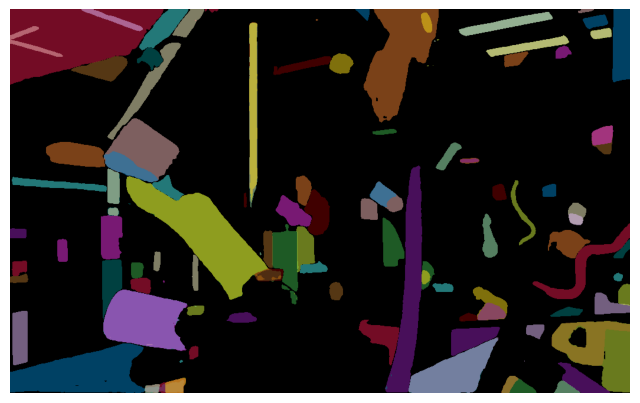

In [ ]:
diff_masks = filter_masks(sam_detections.mask, fast_sam_detections.mask, 0.5)
diff_xyxy = sv.mask_to_xyxy(masks=diff_masks)
diff_detections = sv.Detections(xyxy=diff_xyxy, mask=diff_masks)

mask_annotator = sv.MaskAnnotator()
diff_result = mask_annotator.annotate(scene=np.zeros_like(image_bgr), detections=diff_detections)
sv.plot_image(image=diff_result, size=(8, 8))

## Roboflow Benchmark Dataset

In [ ]:
%cd {HOME}

roboflow.login()
rf = Roboflow()

project = rf.workspace("roboticfish").project("underwater_object_detection")
dataset = project.version(10).download("yolov8")

/content
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics<=8.0.20 is required but found version=8.0.120, to fix: `pip install ultralytics<=8.0.20`
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format

Extracting Dataset Version Zip to underwater_object_detection-10 in yolov8:: 100%|██████████| 5646/5646 [00:01<00:00, 3161.69it/s]


In [ ]:
IMAGE_PATH = os.path.join(dataset.location, 'train', 'images', 'IMG_2311_jpeg_jpg.rf.09ae6820eaff21dc838b1f9b6b20342b.jpg')

In [ ]:
results = fast_sam(
    source=IMAGE_PATH,
    device=DEVICE,
    retina_masks=True,
    imgsz=1024,
    conf=0.5,
    iou=0.6)
prompt_process = FastSAMPrompt(IMAGE_PATH, results, device=DEVICE)
masks = prompt_process.text_prompt(text='Penguin')


image 1/1 /content/underwater_object_detection-10/train/images/IMG_2311_jpeg_jpg.rf.09ae6820eaff21dc838b1f9b6b20342b.jpg: 1024x1024 5 objects, 166.9ms
Speed: 7.2ms preprocess, 166.9ms inference, 4.7ms postprocess per image at shape (1, 3, 1024, 1024)


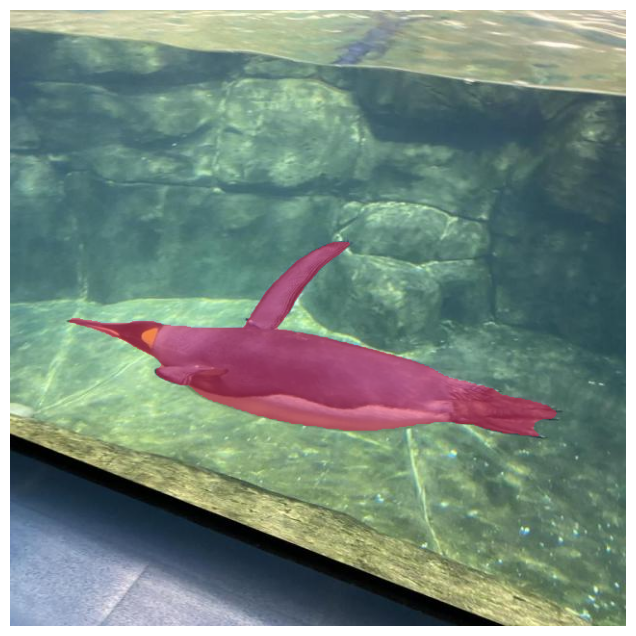

In [ ]:
annotated_image=annotate_image(image_path=IMAGE_PATH, masks=masks)
sv.plot_image(image=annotated_image, size=(8, 8))

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.